In [1]:
%matplotlib widget
from labdata.schema import *
import pylab as plt


plt.matplotlib.rcParams['pdf.fonttype'] = 42
plt.matplotlib.rcParams['ps.fonttype'] = 42
savepath = Path('../../figures/figure4')
savepath.mkdir(parents = True,exist_ok = True)

KILOSORT_PARAMS_SET = 5
METRICS_PARAMS_SET = 1

procedures = ProbeInsertion() * Procedure() & 'procedure_type LIKE "chronic%"'
procedures = pd.DataFrame(procedures.fetch('probe_id', 'subject_name', 'procedure_datetime','procedure_type', order_by='procedure_datetime desc', as_dict=True)).drop_duplicates()
procedures = procedures[::]
first_implant = procedures.procedure_datetime.min()

# sort probe ids by their first implant
implants = procedures[procedures.procedure_type == 'chronic implant']
first_implants = implants.groupby('probe_id')['procedure_datetime'].min().reset_index()
sorted_prbs = first_implants.sort_values('procedure_datetime', ascending=False).probe_id.values

[2024-05-20 14:59:06,464][INFO]: Connecting admin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-05-20 14:59:06,837][INFO]: Connected admin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306


In [6]:
sorted_prbs = ['22420006863',
               '22420007284',  
               '22420007982', 
               '22420007912',
               '22420006801',
               '22420007684',
               '22420007691',
               '22420007301',
               '22420007362', 
               '22420007231',
               '22420007032',
               '20403317093',
               '20403317493',
               '20403312592',
               '20097916762',
               '20097916141',
               '20403314292',
               '20403312442',
               '20403312213',
               '20403312751',
               '20403312621',
               '20403312753',
               '20097916222',
               '20097916182',
               '19454421152',
               '20097902741',
               '20097902851',
               ]
probe_labels = []
for p in sorted_prbs:
    probe_type = (Probe() & f'probe_id = "{p}"').fetch('probe_type')[0]
    if probe_type == '2013':
        pt = 'NP2 '
    elif probe_type == '24':
        pt = 'NP2a '
    else:
        pt = 'NP1 '
    probe_labels.append(pt+p)

In [35]:
UnitCount.populate(display_progress=True,processes = 4)

[2024-05-21 14:28:17,436][WARNING]: MySQL server has gone away. Reconnecting to the server.


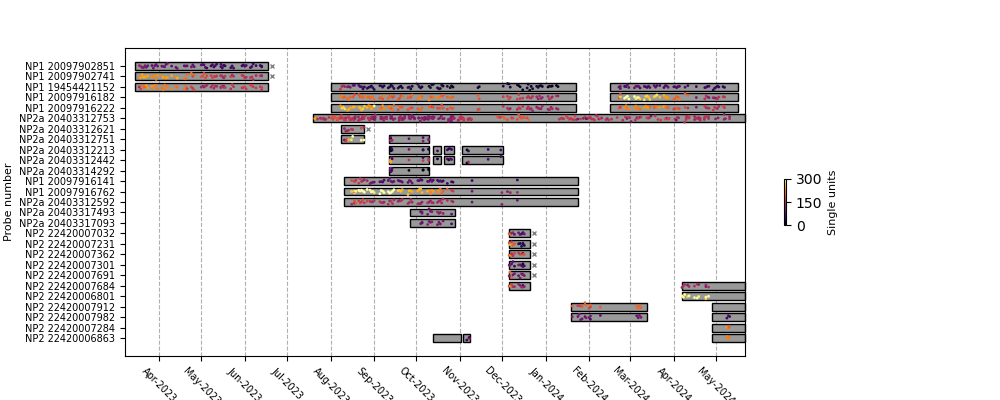

In [36]:

clims=(0,300)
bar_height = .9
bar_distance = 1.2

fig, ax = plt.subplots(figsize=(10,4))
mice = 
prbs, heights = [], []
for prb_ind,prb in enumerate(sorted_prbs):
    implant_times = procedures[(procedures.probe_id == prb) & (procedures.procedure_type == 'chronic implant')].procedure_datetime.values
    explants = pd.DataFrame((Procedure*ProbeExtraction() & f'probe_id = "{prb}"').fetch())
    explant_times = explants.procedure_datetime.values
    height = prb_ind*bar_distance
    for implant in implant_times:
        valid_explants = explant_times[explant_times > implant]
        if len(valid_explants) == 0:
            explant = np.datetime64(datetime.now())
        else:
            explant = valid_explants[np.argmin(valid_explants - implant)]
        plt.barh([height], np.array(explant-implant), left=[implant], height=bar_height, 
                 color='#999999', edgecolor='black',alpha=1,clip_on = False)
        for ie,e in explants.iterrows():
            if e.extraction_successful == 0:
                plt.plot(e.procedure_datetime + timedelta(days = 3),height,'x',markeredgecolor = 'gray',markersize = 3, clip_on = False)
        
    prbs.append(prb)
    heights.append(height)

    #get number of single units for a probe
    units_query = Session() * UnitCount() * EphysRecording.ProbeSetting() & dict(probe_id=prb,
                                                                                 unit_criteria_id=METRICS_PARAMS_SET,
                                                                                 parameter_set_num=KILOSORT_PARAMS_SET)
                                                                                 
    recording_dates, num_single_units = units_query.fetch('session_datetime','sua')
    offset = np.random.normal(0, 0.15, len(recording_dates))
    offset = np.clip(offset, -bar_height/2, bar_height/2)
    #offset = np.random.uniform(-bar_height/2, bar_height/2, len(recording_dates))
    scat = plt.scatter(recording_dates, offset + prb_ind*bar_distance, 
                       s=1, c=np.array(num_single_units), clim=clims, cmap='inferno', alpha=1,clip_on = False)


plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
date_format = plt.matplotlib.dates.DateFormatter('%b-%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)
plt.grid(which='major', axis='x', linestyle='--')
ax.set_axisbelow(True)
plt.ylabel('Probe number',fontsize = 8)
plt.xlabel('Month',fontsize = 8)
from datetime import timedelta
plt.xlim([first_implants.iloc[0].procedure_datetime - timedelta(days=7),datetime.now()])
plt.yticks(heights, probe_labels); # label probes
plt.xticks(rotation=-45);

cbar = plt.colorbar(scat,shrink = 0.15,ticks = [0,150,300])
cbar.set_label('Single units',fontsize = 8)

fig.savefig(savepath/f'recording_summary.pdf')

In [37]:
ComputeTask()

job_id,task_waiting 1 if the job is up for grabs,task_name what task to run,task_status status of the job (did it fail?),"task_target where to run the job, so it only runs where selected",task_host where the job is running,task_cmd command to run,task_parameters command to run after the job finishes,task_log LOG,task_starttime time of task start,task_endtime time of task completion,subject_name unique mouse id,session_name session identifier,dataset_name
1,0,detect,WORKING,aws@gpu-large,gpu-large-dy-g6-1,run detect -a JC131 -s 20230802_184206 20230802_184235 20230803_174514 20230804_180714 20230805_191054 20230806_163038 20230807_172113 20230808_170145 20230810_200741 20230811_181309 20230813_160843 20230814_162930 20230815_160210 20230816_142210 20230817_164351 20230818_125104 20230820_175337 20230821_151418 20230822_163011 20230823_142554 20230824_144002 20230825_151741 20230827_181422 20230828_164145 20230829_172806 20230830_152225 20230905_160426 20230906_172738 20230906_181721 20230907_161,{},ted 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining Completed 38.8 GiB/38.8 GiB (167.5 MiB/s) with 1 file(s) remaining download: s3://churchland-data/JC131/20230802_184206/ephys_g0/ephys_g0_imec0/ephys_g0_t0.imec0.ap.cbin to ../../scratch/JC131/20230802_184206/ephys_g0/ephys_g0_imec0/ephys_g0_t0.imec0.ap.cbin Running spike detection for JC131 20230802_184206 Overriding local_paths and scratch_path. [/scratch] Overriding local_paths and scratch_path. [/scratch],2024-05-21 21:32:20,None,JC131,20230802_184206,ephys_g0
2,0,detect,WORKING,aws@gpu-large,gpu-large-dy-g6-2,run detect -a JC131 -s 20230802_184206 20230802_184235 20230803_174514 20230804_180714 20230805_191054 20230806_163038 20230807_172113 20230808_170145 20230810_200741 20230811_181309 20230813_160843 20230814_162930 20230815_160210 20230816_142210 20230817_164351 20230818_125104 20230820_175337 20230821_151418 20230822_163011 20230823_142554 20230824_144002 20230825_151741 20230827_181422 20230828_164145 20230829_172806 20230830_152225 20230905_160426 20230906_172738 20230906_181721 20230907_161,{},ted 11.9 GiB/11.9 GiB (165.4 MiB/s) with 1 file(s) remaining Completed 11.9 GiB/11.9 GiB (165.5 MiB/s) with 1 file(s) remaining Completed 11.9 GiB/11.9 GiB (165.5 MiB/s) with 1 file(s) remaining Completed 11.9 GiB/11.9 GiB (165.5 MiB/s) with 1 file(s) remaining Completed 11.9 GiB/11.9 GiB (165.5 MiB/s) with 1 file(s) remaining Completed 11.9 GiB/11.9 GiB (165.5 MiB/s) with 1 file(s) remaining Completed 11.9 GiB/11.9 GiB (165.